In [134]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import emcee
import corner
from scipy.optimize import curve_fit
from scipy.stats.distributions import chi2
from scipy.stats import multivariate_normal, norm
from os import listdir
from tqdm import tqdm_notebook as tqdm
import matplotlib as mpl
%matplotlib inline

new_rc_params = {'text.usetex': False,
    "svg.fonttype": 'none'
    }
mpl.rcParams.update(new_rc_params)

In [135]:
#Voting history from all 51 'states' since 1976
votinghistory_full = np.loadtxt('1976-2020-president.csv', delimiter=',', skiprows=1, usecols=(0, 1, 10, 11, 14), 
                                dtype=[('year', int), ('state', 'U25'), ('votes', int), ('total_votes', int), 
                                       ('party', 'U20')])
print(votinghistory_full)

[(1976, 'ALABAMA', 659170, 1182850, 'DEMOCRAT')
 (1976, 'ALABAMA', 504070, 1182850, 'REPUBLICAN')
 (1976, 'ALABAMA',   9198, 1182850, 'OTHER') ...
 (2020, 'WYOMING',   1739,  278503, 'OTHER')
 (2020, 'WYOMING',    279,  278503, 'OTHER')
 (2020, 'WYOMING',   1459,  278503, 'OTHER')]


In [136]:
#Voting results from only Democratic and Republican candidates
index_dem = votinghistory_full['party'] == 'DEMOCRAT'
index_rep = votinghistory_full['party'] == 'REPUBLICAN'
votinghistory_dem = votinghistory_full[index_dem] # democrat results only
votinghistory_rep = votinghistory_full[index_rep] # republican results only
votinghistory = np.concatenate([votinghistory_dem, votinghistory_rep]) # combined results

In [137]:
#Array of states in alphabetical order
states = np.unique(votinghistory['state'])

In [138]:
# Now, considering all races between 1976 and 2016, we calculate the mean voteshare and variance for each state,
# for each party, along with the full covariance matrix

#Democrats
index_dem_2016 = votinghistory_dem['year'] != 2020
years = np.unique(votinghistory_dem[index_dem_2016]['year'])
votinghistory_dem_2016 = votinghistory_dem[index_dem_2016]
voteshare_dem = []
for i in range(len(states)):
    state = states[i]
    index = votinghistory_dem_2016['state'] == str(state)
    array = votinghistory_dem_2016[index]
    out = []
    for j in range(len(years)):
        voteshare = array[j][2] / array[j][3]
        out.append(voteshare)
    voteshare_dem.append(out)
cov_dem = np.cov(voteshare_dem, bias = True, dtype=np.float64)
var_dem = np.diag(cov_dem)
mean_dem = np.mean(voteshare_dem, axis = 1)

#Republicans
index_rep_2016 = votinghistory_rep['year'] != 2020
years = np.unique(votinghistory_rep[index_rep_2016]['year'])
votinghistory_rep_2016 = votinghistory_rep[index_rep_2016]
voteshare_rep = []
for i in range(len(states)):
    state = states[i]
    index = votinghistory_rep_2016['state'] == str(state)
    array = votinghistory_rep_2016[index]
    out = []
    for j in range(len(years)):
        voteshare = array[j][2] / array[j][3]
        out.append(voteshare)
    voteshare_rep.append(out)
cov_rep = np.cov(voteshare_rep, bias = True)
var_rep = np.diag(voteshare_rep)
mean_rep = np.mean(voteshare_rep, axis = 1)

In [139]:
# Ingesting polling data from 2020 election
polling_averages = np.loadtxt('presidential_general_averages.csv', delimiter=',', skiprows = 1, usecols = (0, 1, 2, 3), 
                              dtype=[('candidate', 'U20'), ('date', 'U10'), ('approval', float), ('state', 'U25')])

index_biden = polling_averages['candidate'] == 'Joseph R. Biden Jr.'
index_trump = polling_averages['candidate'] == 'Donald Trump'
polls_biden = polling_averages[index_biden]
polls_trump = polling_averages[index_trump]

In [140]:
# Organizing polling data by state to establish covariance matrix for multivariate normal likelihood

states_lowercase = np.unique(polling_averages['state'])
polling_dates = np.unique(polling_averages['date'])

# Joe Biden
polls_biden_bystate = []
polls_biden_national = []
for i in range(len(states_lowercase)):
    state = states_lowercase[i]
    index = polls_biden['state'] == str(state)
    array = polls_biden[index]
    mean = np.mean(array['approval'])
    stdv = np.std(array['approval'])
    if state == 'ME-1':
        continue
    if state == 'ME-2':
        continue
    if state == 'NE-2':
        continue
    if state == 'National':
        polls_biden_national.append(array)
    else:
        out = []
        for j in range(len(polling_dates)):
            date = polling_dates[j]
            datapoint = array[array['date'] == str(date)]
            if not datapoint.tolist():
                new_datapoint = np.random.normal(mean, stdv) * 0.01
                out.append(new_datapoint)
            else:
                out.append(datapoint['approval'][0] * 0.01)
        polls_biden_bystate.append(out)
polls_biden_cov = np.cov(polls_biden_bystate, bias = True)

# Donald Trump
polls_trump_bystate = []
polls_trump_national = []
for i in range(len(states_lowercase)):
    state = states_lowercase[i]
    index = polls_trump['state'] == str(state)
    array = polls_trump[index]
    mean = np.mean(array['approval'])
    stdv = np.std(array['approval'])
    if state == 'ME-1':
        continue
    if state == 'ME-2':
        continue
    if state == 'NE-2':
        continue
    if state == 'National':
        polls_trump_national.append(array)
    else:
        out = []
        for j in range(len(polling_dates)):
            date = polling_dates[j]
            datapoint = array[array['date'] == str(date)]
            if not datapoint.tolist():
                new_datapoint = np.random.normal(mean, stdv) * 0.01
                out.append(new_datapoint)
            else:
                out.append(datapoint['approval'][0] * 0.01)
        polls_trump_bystate.append(out)
polls_trump_cov = np.cov(polls_trump_bystate, bias = True)
print(len(polls_trump_cov))

51


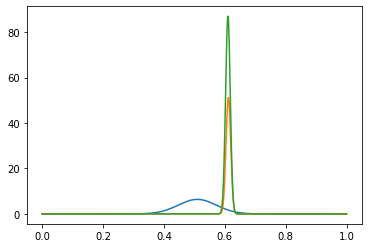

In [120]:
state = 'California'
index = polls_biden['state'] == str(state)
array = polls_biden[index]
mean = np.mean(array['approval'])
stdv = np.std(array['approval'])

x = np.linspace(0, 1, 1000)
factor = 10
plt.plot(x, norm.pdf(x, mean_dem[4], np.diag(cov_dem)[4] * factor))
plt.plot(x, norm.pdf(x, mean * 0.01, stdv * 0.01))
plt.plot(x, norm.pdf(x, mean_dem[4], np.diag(cov_dem)[4] * factor) * norm.pdf(x, mean * 0.01, stdv * 0.01))

In [27]:
# Implementing MCMC
# Prior
def prior(mu, mu_0, sigma_0):
    return multivariate_normal.pdf(mu, mu_0, sigma_0, allow_singular = True)

# Likelihood
def likelihood(mu, polls, sigma):
    polls_l = np.asarray(polls).T
    index = len(polls_l)
    probs = []
    for i in range(index):
        prob = multivariate_normal.pdf(polls_l[i], mu, sigma, allow_singular = True)
        probs.append(prob)
    return np.prod(np.asarray(probs))

# Posterior
def log_post(mu, polls, sigma, mu_0, sigma_0):
    like = likelihood(mu, polls, sigma)
    pri = prior(mu, mu_0, sigma_0)
    post = like * pri
    if post > 0.:
        return np.log(post)
    else: return -np.inf

In [11]:
# MCMC
num_iter = 5000
ndim = 51
nwalkers = ndim * 2
initial_pos = np.array(mean_dem) + 0.01 * np.random.randn(nwalkers, ndim)
print(initial_pos)
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_post, 
                                args=[polls_biden_bystate, polls_biden_cov, mean_dem, cov_dem])
sampler.run_mcmc(initial_pos, num_iter, progress=True, skip_initial_state_check = True);

[[0.42520474 0.33287527 0.4128676  ... 0.44566045 0.47967173 0.30965349]
 [0.40870692 0.3443046  0.38407937 ... 0.46230026 0.48031373 0.31797789]
 [0.40896387 0.34439444 0.38378544 ... 0.45965944 0.48524805 0.29129935]
 ...
 [0.41078394 0.34186258 0.3992775  ... 0.44095992 0.49024675 0.3106862 ]
 [0.40400803 0.3463881  0.38893767 ... 0.45561336 0.4779559  0.31294965]
 [0.40860425 0.33135624 0.39597478 ... 0.48194661 0.48409191 0.29953037]]


100%|██████████| 5000/5000 [13:35:54<00:00,  9.79s/it]  


In [12]:
chain = sampler.get_chain(discard=100, flat=True)
first_sim = np.savetxt('first_sim.csv', chain, delimiter=',')

[[0.42520474 0.40870692 0.40896387 ... 0.41078394 0.40400803 0.40860425]
 [0.33287527 0.3443046  0.34439444 ... 0.34186258 0.3463881  0.33135624]
 [0.4128676  0.38407937 0.38378544 ... 0.3992775  0.38893767 0.39597478]
 ...
 [0.44566045 0.46230026 0.45965944 ... 0.44095992 0.45561336 0.48194661]
 [0.47967173 0.48031373 0.48524805 ... 0.49024675 0.4779559  0.48409191]
 [0.30965349 0.31797789 0.29129935 ... 0.3106862  0.31294965 0.29953037]]


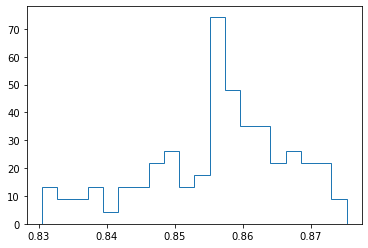

In [52]:
plt.hist(chain.T[8], bins = 20, density = True, histtype='step')
print(chain.T)

In [19]:
# MCMC Republican
num_iter = 6000
ndim = 51
nwalkers = ndim * 2
initial_pos = np.array(mean_rep) + 0.01 * np.random.randn(nwalkers, ndim)
print(initial_pos)
sampler_rep = emcee.EnsembleSampler(nwalkers, ndim, log_post, 
                                args=[polls_trump_bystate, polls_trump_cov, mean_rep, cov_rep])
sampler_rep.run_mcmc(initial_pos, num_iter, progress=True, skip_initial_state_check = True);

chain_rep = sampler_rep.get_chain(discard=100, flat=True)
first_sim = np.savetxt('first_sim_rep.csv', chain_rep, delimiter=',')

[[0.55523962 0.55695769 0.55068922 ... 0.50044312 0.44916211 0.61009249]
 [0.54879973 0.56505465 0.52262305 ... 0.50855211 0.4626784  0.62828517]
 [0.56191024 0.57802386 0.53386116 ... 0.49811526 0.46765806 0.61395844]
 ...
 [0.57009039 0.55590725 0.53823916 ... 0.49990054 0.47296965 0.61482714]
 [0.5718474  0.57211746 0.53854467 ... 0.50749413 0.44618822 0.6074123 ]
 [0.53561973 0.55344881 0.53014507 ... 0.48185114 0.44448659 0.60614581]]


100%|██████████| 6000/6000 [16:23:13<00:00,  9.83s/it]  


In [67]:
# We Assume the parameters are normally distributed and calculate the mean

post_means_dem = np.mean(chain.T, axis = 1)
post_means_rep = np.mean(chain_rep.T, axis = 1)

In [86]:
print(post_means_dem), print(np.diag(polls_biden_cov))

[0.41290006 0.33749179 0.40400363 0.45489959 0.50828523 0.43689451
 0.49934962 0.50635809 0.85624576 0.45132726 0.46446453 0.55564273
 0.30997008 0.51770848 0.40990665 0.47777202 0.3724179  0.42501231
 0.4391345  0.47700307 0.54115442 0.55487454 0.48433898 0.50094545
 0.42429348 0.45472413 0.39790968 0.34289886 0.43224773 0.43399596
 0.49415709 0.47264786 0.52687932 0.45425312 0.36431379 0.45699774
 0.36166581 0.48276109 0.48844017 0.55694523 0.43315848 0.39680171
 0.44120895 0.41502303 0.2788869  0.51413735 0.4498181  0.48844773
 0.45190282 0.48365349 0.31263663]
[3.65110372e-05 4.59670361e-05 8.34598061e-05 8.02109770e-04
 6.06486014e-05 8.11046928e-04 4.05315464e-04 1.55826821e-04
 1.79899329e-04 8.00495725e-05 8.08491192e-05 8.90743475e-04
 1.90617786e-04 1.23535315e-04 7.32630638e-05 1.19508741e-04
 7.93706418e-05 3.01458066e-05 1.10262618e-04 1.14902062e-04
 9.21872676e-05 2.73233096e-04 1.48324006e-04 2.65743421e-04
 4.70783974e-05 9.25087465e-05 1.59294275e-03 9.19911687e-05
 1

(None, None)

In [28]:
import montecarlo
%load_ext autoreload
%autoreload 2

In [38]:
dem_post = np.loadtxt('first_sim_dem.csv', delimiter = ',')
dem_mean = np.mean(dem_post, axis = 0)

In [40]:
print(len(dem_mean))
print(dem_mean)

51
[0.41290006 0.33749179 0.40400363 0.45489959 0.50828523 0.43689451
 0.49934962 0.50635809 0.85624576 0.45132726 0.46446453 0.55564273
 0.30997008 0.51770848 0.40990665 0.47777202 0.3724179  0.42501231
 0.4391345  0.47700307 0.54115442 0.55487454 0.48433898 0.50094545
 0.42429348 0.45472413 0.39790968 0.34289886 0.43224773 0.43399596
 0.49415709 0.47264786 0.52687932 0.45425312 0.36431379 0.45699774
 0.36166581 0.48276109 0.48844017 0.55694523 0.43315848 0.39680171
 0.44120895 0.41502303 0.2788869  0.51413735 0.4498181  0.48844773
 0.45190282 0.48365349 0.31263663]


In [66]:
runs = 100000
montecarlo_dem = montecarlo.montecarlo(runs, dem_mean, polls_biden_cov)

  0%|          | 0/100000 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Dem Electoral College Outcome')

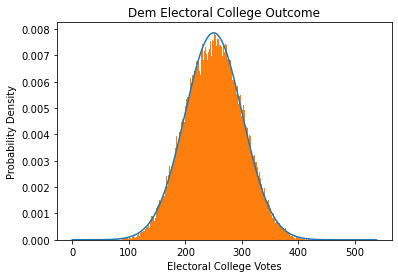

In [67]:
bins = np.linspace(0, 538, 539)

mu, sigma = norm.fit(montecarlo_dem[0])
best_fit_line = norm.pdf(bins, mu, sigma)
plt.plot(bins, best_fit_line)

plt.hist(montecarlo_dem[0], bins, density = True)
plt.xlabel('Electoral College Votes')
plt.ylabel('Probability Density')
plt.title('Dem Electoral College Outcome')

(0.42, 0.515)

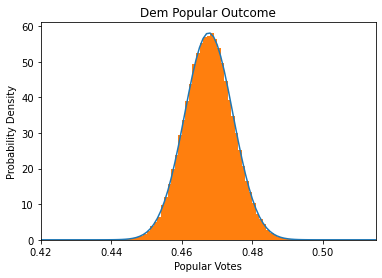

In [72]:
bins = np.linspace(0, 1, 1001)

mu, sigma = norm.fit(montecarlo_dem[4])
best_fit_line = norm.pdf(bins, mu, sigma)
plt.plot(bins, best_fit_line)

plt.hist(montecarlo_dem[4], bins, density = True)
plt.xlabel('Popular Votes')
plt.ylabel('Probability Density')
plt.title('Dem Popular Outcome')
plt.xlim(0.42, 0.515)

## Second Simulation with Historical Covariance

In [141]:
## Revised MCMC

# Prior
def prior(mu, mu_0, sigma_0):
    return multivariate_normal.logpdf(mu, mu_0, sigma_0, allow_singular = True)

# Likelihood
def likelihood(mu, polls, sigma):
    polls_l = np.asarray(polls).T
    index = len(polls_l)
    probs = []
    for i in range(index):
        prob = multivariate_normal.logpdf(polls_l[i], mu, sigma, allow_singular = True)
        probs.append(prob)
    return np.sum(np.asarray(probs))

# Posterior
def log_post(mu, polls, sigma, mu_0, sigma_0):
    like = likelihood(mu, polls, sigma)
    pri = prior(mu, mu_0, sigma_0)
    if (not np.isfinite(like))|(not np.isfinite(pri)):
        return -np.inf
    return like + pri

In [142]:
revised_cov_dem = cov_dem * 10

# MCMC
num_iter = 9000
ndim = 51
nwalkers = ndim * 2
initial_pos = np.array(mean_dem) + 0.01 * np.random.randn(nwalkers, ndim)
print(initial_pos)
test = emcee.EnsembleSampler(nwalkers, ndim, log_post, 
                                args=[polls_biden_bystate, polls_biden_cov, mean_dem, revised_cov_dem])
test.run_mcmc(initial_pos, num_iter, progress=True, skip_initial_state_check = True);

[[0.42390459 0.33509326 0.41475568 ... 0.45891434 0.48693861 0.30330732]
 [0.39885527 0.34155021 0.4077562  ... 0.45422229 0.48715141 0.32015077]
 [0.41187736 0.35194287 0.42229004 ... 0.44647498 0.47249466 0.31670543]
 ...
 [0.40654754 0.33015725 0.41675768 ... 0.44672857 0.50082975 0.30856388]
 [0.41734026 0.33864811 0.40660327 ... 0.46910341 0.48042291 0.31843761]
 [0.40261478 0.33816393 0.40503241 ... 0.46302998 0.49023537 0.31975831]]


  0%|          | 9/10000 [01:09<21:46:41,  7.85s/it]Traceback (most recent call last):
  File "/Users/jmanlarkin/anaconda3/lib/python3.9/site-packages/emcee/ensemble.py", line 624, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/var/folders/bm/j5pxyqnj5dq28k2jcxxwlzpr0000gn/T/ipykernel_1041/924967010.py", line 19, in log_post
    like = likelihood(mu, polls, sigma)
  File "/var/folders/bm/j5pxyqnj5dq28k2jcxxwlzpr0000gn/T/ipykernel_1041/924967010.py", line 13, in likelihood
    prob = multivariate_normal.logpdf(polls_l[i], mu, sigma, allow_singular = True)
  File "/Users/jmanlarkin/anaconda3/lib/python3.9/site-packages/scipy/stats/_multivariate.py", line 491, in logpdf
    psd = _PSD(cov, allow_singular=allow_singular)
  File "/Users/jmanlarkin/anaconda3/lib/python3.9/site-packages/scipy/stats/_multivariate.py", line 158, in __init__
    s, u = scipy.linalg.eigh(M, lower=lower, check_finite=check_finite)
  File "/Users/jmanlarkin/anaconda3/lib/python3.9/site-package

emcee: Exception while calling your likelihood function:
  params: [0.40883023 0.34286082 0.42253384 0.46184585 0.49416974 0.45317098
 0.50687527 0.53009973 0.83413055 0.44206974 0.48502535 0.56977672
 0.3125144  0.53601161 0.37977597 0.48806501 0.39143587 0.42770925
 0.44635948 0.43999947 0.52407928 0.55224629 0.47414592 0.49054099
 0.41771944 0.4550736  0.35571194 0.34824989 0.44090936 0.40237076
 0.49493151 0.49953551 0.51762175 0.460574   0.3568911  0.44626239
 0.36772015 0.48376118 0.48015221 0.55264407 0.43575386 0.3740845
 0.42021257 0.44076675 0.324464   0.53797972 0.44067339 0.48820723
 0.43150391 0.48196453 0.29795899]
  args: [[[0.3822156, 0.383919, 0.3838301, 0.3838301, 0.38386270000000006, 0.3839524, 0.383974, 0.3837068, 0.3837094, 0.3861198, 0.38679209999999997, 0.3856548, 0.38529310000000005, 0.38407490000000005, 0.3845166, 0.3860841, 0.38607660000000005, 0.3855511, 0.38495429999999997, 0.3849648, 0.3849648, 0.3875629, 0.3874162, 0.38739640000000003, 0.386665, 0.3861094,

KeyboardInterrupt: 